<a href="https://colab.research.google.com/github/NikolaosBouas/Model-Inversion-VFL-SplitNN/blob/main/Model_Inversion_SplitNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Inversion Attack on Split Neural Networks for Vertical Federated Learning

- <b>Alice</b>
    - Has model Segment 1
    - Has the handwritten Images
- <b>Bob</b>
    - Has model Segment 2
    - Has the image Labels

In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Cloning the PyVertical repository to use modules contained there.

In [4]:
!git clone https://github.com/OpenMined/PyVertical.git

Cloning into 'PyVertical'...
remote: Enumerating objects: 1129, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 1129 (delta 31), reused 45 (delta 20), pack-reused 1060
Receiving objects: 100% (1129/1129), 24.43 MiB | 26.81 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [1]:
%cd PyVertical

/content/PyVertical


Installing necessary packages.

In [6]:
!pip install syft=="0.2.2a1"
!pip install syft_proto=="0.1.1a1.post17"
!pip install openmined.psi

     |████████████████████████████████| 337kB 20.2MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 773.1MB 24kB/s 
     |████████████████████████████████| 10.2MB 33.1MB/s 
     |████████████████████████████████| 1.8MB 45.0MB/s 
     |████████████████████████████████| 522kB 52.7MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 2.1MB 46.0MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
  Created wheel for phe: filename=phe-1.4.0-py2.py3-none-any.whl size=37362 sha256=78e8eba1a3909cd45a998e475ef58d376854d6ff33af4831c4716fe02f283b0a
  Stored in directory: /root/.cache/pip/wheels/f8/dc/36/dcb6bf0f1b9907e7b710ace63e64d08e7022340909315fdea4
  Created wheel for zstd: filename=zstd-1.4.9.1-cp37-cp37m-linux_x86_64.whl size=1212721 sha256=0fe33f78b4c0b8b51811ac5ba09bdffa7521e5a98b

     |████████████████████████████████| 40kB 5.1MB/s 
  Found existing installation: syft-proto 0.5.3
    Uninstalling syft-proto-0.5.3:
      Successfully uninstalled syft-proto-0.5.3
     |████████████████████████████████| 1.9MB 16.4MB/s 


Importing necessary dependencies.

In [2]:
from torchvision.utils import make_grid
import numpy as np
import pickle

In [3]:
import sys
sys.path.append('../')

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import torch.nn.functional as F

from src.dataloader import VerticalDataLoader
from src.psi.util import Client, Server
from src.utils import add_ids

hook = sy.TorchHook(torch)

In [4]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


In [5]:
# Create dataset
data = add_ids(MNIST)(".", download=True, transform=ToTensor())  # add_ids adds unique IDs to data points

# Batch data
dataloader = VerticalDataLoader(data, batch_size=64) # partition_dataset uses by default "remove_data=True, keep_order=False"

In [6]:
GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


Defining the split neural network.

In [7]:
class SplitNN:
    def __init__(self, models, optimizers, noisy = False, variance = 5):
        self.models = models
        self.optimizers = optimizers
        self.noisy = noisy
        self.variance = variance

        self.data = []
        self.remote_tensors = []

    def forward(self, x):
        data = []
        remote_tensors = []

        if(not self.noisy):
            data.append(self.models[0](x))
        else:
            noise = (self.variance**0.5)*torch.randn(x.shape[0], 640)
            noise = noise.send(self.models[0].location).to(device)
            data.append(self.models[0](x) + noise)

        if data[-1].location == self.models[1].location:
            remote_tensors.append(data[-1].detach().requires_grad_())
        else:
            remote_tensors.append(
                data[-1].detach().move(self.models[1].location).requires_grad_()
            )

        i = 1
        while i < (len(models) - 1):
            data.append(self.models[i](remote_tensors[-1]))

            if data[-1].location == self.models[i + 1].location:
                remote_tensors.append(data[-1].detach().requires_grad_())
            else:
                remote_tensors.append(
                    data[-1].detach().move(self.models[i + 1].location).requires_grad_()
                )

            i += 1

        data.append(self.models[i](remote_tensors[-1]))

        self.data = data
        self.remote_tensors = remote_tensors

        return data[-1]

    def backward(self):
        for i in range(len(models) - 2, -1, -1):
            if self.remote_tensors[i].location == self.data[i].location:
                grads = self.remote_tensors[i].grad.copy()
            else:
                grads = self.remote_tensors[i].grad.copy().move(self.data[i].location)
    
            self.data[i].backward(grads)

    def zero_grads(self):
        for opt in self.optimizers:
            opt.zero_grad()

    def step(self):
        for opt in self.optimizers:
            opt.step()

Loading the data.

Check if the datasets are ordered.

8 4 3 8 7 3 0 1 0 1 

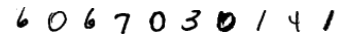

In [8]:
# We need matplotlib library to plot the dataset
import matplotlib.pyplot as plt

# Plot the first 10 entries of the labels and the dataset
figure = plt.figure()
num_of_entries = 10
for index in range(1, num_of_entries + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(dataloader.dataloader1.dataset.data[index].numpy().squeeze(), cmap='gray_r')
    print(dataloader.dataloader2.dataset[index][0], end=" ")

Since the datasets are not ordered we perform PSI to align them.

In [9]:
# Compute private set intersection
client_items = dataloader.dataloader1.dataset.get_ids()
server_items = dataloader.dataloader2.dataset.get_ids()

client = Client(client_items)
server = Server(server_items)

setup, response = server.process_request(client.request, len(client_items))
intersection = client.compute_intersection(setup, response)

# Order data
dataloader.drop_non_intersecting(intersection)
dataloader.sort_by_ids()

Check again if the datasets are ordered and see that they are!

3 4 2 4 5 5 6 5 6 2 

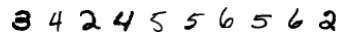

In [10]:
# We need matplotlib library to plot the dataset
import matplotlib.pyplot as plt

# Plot the first 10 entries of the labels and the dataset
figure = plt.figure()
num_of_entries = 10
for index in range(1, num_of_entries + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(dataloader.dataloader1.dataset.data[index].numpy().squeeze(), cmap='gray_r')
    print(dataloader.dataloader2.dataset[index][0], end=" ")

Define the sub-models that Alice and Bob hold. Change the split_layer parameter to 9, 11, 13, 15, 17 to specify that split layer is the first, second, third, fourth or fifth fully connected layer respectively.

In [22]:
torch.manual_seed(0)

# Define our model segments
split_layer = 17
output_size = 10
init_channels = 16
image_channels = 1
kernel_size = 4
hidden_sizes = [64*36, 640]

modules = []
modules.append(
        nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
            )
        )
modules.append(nn.ReLU())
modules.append(
        nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
            )
        )
modules.append(nn.ReLU())
modules.append(
        nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=1
            )
        )
modules.append(nn.ReLU())
modules.append(nn.Flatten())
modules.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], output_size))
modules.append(nn.LogSoftmax(dim=1))


models = [
    nn.Sequential(*modules[:split_layer]),
    nn.Sequential(*modules[split_layer:]),
]

for model in models:
    model = model.to(device)

# Create optimisers for each segment and link to them
optimizers = [
    optim.Adam(model.parameters(), lr=0.001,)
    for model in models
]

# create some workers
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")

# Send Model Segments to model locations
model_locations = [alice, bob]
for model, location in zip(models, model_locations):
    model.send(location)

#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = SplitNN(models, optimizers)

Function to train the Split NN.

In [23]:
def train(x, target, splitNN):
    
    #1) Zero our grads
    splitNN.zero_grads()
    
    #2) Make a prediction
    pred = splitNN.forward(x)
    
    #3) Figure out how much we missed by
    criterion = nn.NLLLoss()
    loss = criterion(pred, target)
    
    #4) Backprop the loss on the end layer
    loss.backward()
    
    #5) Feed Gradients backward through the nework
    splitNN.backward()
    
    #6) Change the weights
    splitNN.step()
    
    return loss, pred

We train the network for 5 epochs and observe that we get sufficiently high accuracy. The dataset is really easy and getting a high accuracy is not the point of this notebook.

In [24]:
epochs = 5

for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    for (data, ids1), (labels, ids2) in dataloader:
        # Train a model
        data, labels = data.to(device), labels.to(device)
        data = data.send(models[0].location)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = train(data, labels, splitNN)

        # Collect statistics
        running_loss += loss.get()
        correct_preds += preds.max(1)[1].eq(labels).sum().get().item()
        total_preds += preds.get().size(0)

    print(f"Epoch {i} - Training loss: {running_loss/len(dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

Epoch 0 - Training loss: 0.453 - Accuracy: 83.903
Epoch 1 - Training loss: 0.077 - Accuracy: 97.995
Epoch 2 - Training loss: 0.051 - Accuracy: 98.690
Epoch 3 - Training loss: 0.045 - Accuracy: 98.898
Epoch 4 - Training loss: 0.035 - Accuracy: 99.200


In [25]:
print("Labels pointing to: ", labels)
print("Images pointing to: ", data)

Labels pointing to:  (Wrapper)>[PointerTensor | me:29315833037 -> bob:59759751522]
Images pointing to:  (Wrapper)>[PointerTensor | me:30457927442 -> alice:48377016422]


Now let's say a malicious adversary has access to the smashed data that Alice outputs as well as the corresponding inputs. Then the malicious adversary will try to train a model that reconstructs the original input based on the smashed data. We define the architecture of the adversary's model.

In [26]:
# *CODE FOR PART 1.1a IN THIS CELL*

class adversary_model(nn.Module):
    def __init__(self):
        super(adversary_model, self).__init__()

        self.fc = nn.Linear(hidden_sizes[1], hidden_sizes[0])

        #Upsampling 
        self.up1 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.up2 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.up3 = nn.ConvTranspose2d(
            in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )


    def forward(self, z):

        z = F.relu(self.fc(z))
        z = z.view(-1, 64, 6, 6)
        x = F.relu(self.up1(z))
        x = F.relu(self.up2(x))

        reconstruction = self.up3(x)
        return reconstruction



adv_model = adversary_model().to(device)
print(adv_model)
#we assume Bob has the adversary
adv_model.send(model_locations[-1])
# optimizer
adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=0.001)

adversary_model(
  (fc): Linear(in_features=640, out_features=2304, bias=True)
  (up1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (up2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up3): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


We define a simple L1Loss. There may have been better loss options but we are interested in a qualitative comparison between different split options and not in achieving the best reconstruction quality.

In [27]:
def reconstruction_loss(img1, img2):
    return nn.L1Loss()(img1, img2)

We train this model for 5 epochs and observe the results.

In [28]:
epochs = 5

for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    for (data, ids1), (labels, ids2) in dataloader:
        # Train a model
        adv_optimizer.zero_grad()
        data, labels = data.to(device), labels.to(device)

        #Send data to Alice to get smashed data 
        data = data.send(models[0].location)
        z = models[0](data)

        #Send smashed data and original input to adversary. Here we assume the 
        #adversary is Bob. It could be anyone.
        data = data.move(models[-1].location)
        recon_input = adv_model(z.detach().move(models[-1].location).requires_grad_()).to(device)

        loss = reconstruction_loss(recon_input, data)

        loss.backward()
        
        adv_optimizer.step()
        
        running_loss += loss.get()

    print(f"Epoch {i} - Training loss: {running_loss/len(dataloader):.3f}")

Epoch 0 - Training loss: 0.108
Epoch 1 - Training loss: 0.102
Epoch 2 - Training loss: 0.100
Epoch 3 - Training loss: 0.098
Epoch 4 - Training loss: 0.097


In [29]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

We pick 32 random images, pass them through Alice's network, assume that the adversary intercepts the smashed data and observe the reconstruction quality. The results presented here are for the split performed on the fifth fully connected layer. Vary the split_layer parameter accordingly to change this.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------


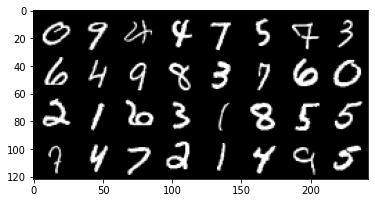

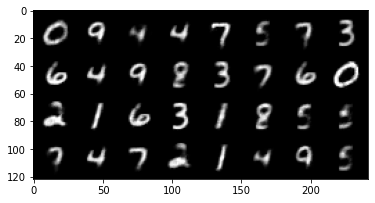

In [30]:
# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(dataloader))
#fixed_input = sample_inputs[0][:32]
#stored the inputs in drive to get same data for comparison
#uncomment previous line for different data
# save fixed_input
#with open('/content/drive/My Drive/fixed_input.pickle', 'wb') as handle:
#    pickle.dump(fixed_input, handle)

with open('/content/drive/My Drive/fixed_input.pickle', 'rb') as handle:
    fixed_input = pickle.load(handle)
    
# visualize the original images of the last batch of the test set
img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)
print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    fixed_input = fixed_input.send(models[0].location)
    z = models[0](fixed_input.to(device))
    recon_batch = adv_model(z.detach().move(models[-1].location))
    recon_batch = recon_batch.view(32, 28, 28).unsqueeze(1)

    
    recon_batch = recon_batch.cpu().get()
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

We will further examine a very simple defense mechanism. Alice will insert some noise on the input data before releasing it to Bob. We expect the accuracy to decrease by a small amount but also worse reconstruction quality. The noise will be Gaussian with mean 0 and variance 5.


In [17]:
split_layer = 17

modules = []
modules.append(
        nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
            )
        )
modules.append(nn.ReLU())
modules.append(
        nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
            )
        )
modules.append(nn.ReLU())
modules.append(
        nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=1
            )
        )
modules.append(nn.ReLU())
modules.append(nn.Flatten())
modules.append(nn.Linear(hidden_sizes[0], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], hidden_sizes[1]))
modules.append(nn.ReLU())
modules.append(nn.Linear(hidden_sizes[1], output_size))
modules.append(nn.LogSoftmax(dim=1))


models = [
    nn.Sequential(*modules[:split_layer]),
    nn.Sequential(*modules[split_layer:]),
]

for model in models:
    model = model.to(device)

# Create optimisers for each segment and link to them
optimizers = [
    optim.Adam(model.parameters(), lr=0.001,)
    for model in models
]

# create some workers
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")

# Send Model Segments to model locations
model_locations = [alice, bob]
for model, location in zip(models, model_locations):
    model.send(location)

#Instantiate a SpliNN class with our distributed segments and their respective optimizers
#noisy=True ensures that gaussian noise is added to Alice's output.
noisySplitNN = SplitNN(models, optimizers, noisy = True, variance = 5)

We train the SplitNN and see that the accuracy remains sufficiently high.

In [18]:
epochs = 5

for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    for (data, ids1), (labels, ids2) in dataloader:
        # Train a model
        data, labels = data.to(device), labels.to(device)
        data = data.send(models[0].location)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = train(data, labels, noisySplitNN)

        # Collect statistics
        running_loss += loss.get()
        correct_preds += preds.max(1)[1].eq(labels).sum().get().item()
        total_preds += preds.get().size(0)

    print(f"Epoch {i} - Training loss: {running_loss/len(dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

Epoch 0 - Training loss: 0.461 - Accuracy: 85.958
Epoch 1 - Training loss: 0.108 - Accuracy: 97.503
Epoch 2 - Training loss: 0.076 - Accuracy: 98.250
Epoch 3 - Training loss: 0.067 - Accuracy: 98.542
Epoch 4 - Training loss: 0.066 - Accuracy: 98.648


We then define and train the adversary model/

In [19]:
adv_model = adversary_model().to(device)
print(adv_model)
#we assume Bob has the adversary
adv_model.send(model_locations[-1])
# optimizer
adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=0.001)

adversary_model(
  (fc): Linear(in_features=640, out_features=2304, bias=True)
  (up1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (up2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up3): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [20]:
epochs = 5
variance = 5

for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0

    for (data, ids1), (labels, ids2) in dataloader:
        # Train a model
        adv_optimizer.zero_grad()

        data, labels = data.to(device), labels.to(device)
        
        #Send data to Alice to get shashed data 
        data = data.send(models[0].location)
        noise = (variance**0.5)*torch.randn(data.shape[0], 640)
        noise = noise.send(models[0].location).to(device)
        z = models[0](data) + noise

        #Send smashed data and original input to adversary. Here we assume the 
        #adversary is Bob. It could be anyone.
        data = data.move(models[-1].location)
        recon_input = adv_model(z.detach().move(models[-1].location).requires_grad_()).to(device)

        loss = reconstruction_loss(recon_input, data)

        loss.backward()

        adv_optimizer.step()
        
        running_loss += loss.get()

    print(f"Epoch {i} - Training loss: {running_loss/len(dataloader):.3f}")

Epoch 0 - Training loss: 0.116
Epoch 1 - Training loss: 0.103
Epoch 2 - Training loss: 0.102
Epoch 3 - Training loss: 0.101
Epoch 4 - Training loss: 0.101


We intercept smashed data again and try to reconstruct the input. We can now see that the reconstruction quality is much worse. Thus, even such a simple defense mechanism can protect against this type of attack.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------


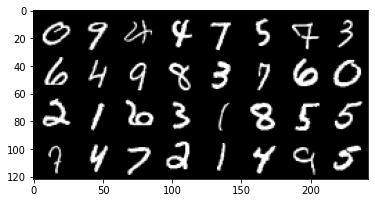

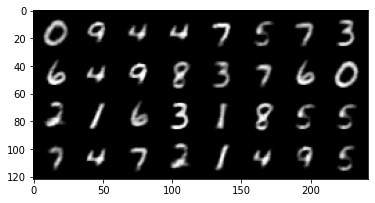

In [21]:
# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(dataloader))
#fixed_input = sample_inputs[0][:32]
#stored the inputs in drive to get same data for comparison
#uncomment previous line for different data
# save fixed_input
#with open('/content/drive/My Drive/fixed_input.pickle', 'wb') as handle:
#    pickle.dump(fixed_input, handle)

with open('/content/drive/My Drive/fixed_input.pickle', 'rb') as handle:
    fixed_input = pickle.load(handle)
    
# visualize the original images of the last batch of the test set
img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)
print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    fixed_input = fixed_input.send(models[0].location)
    noise = (variance**0.5)*torch.randn(32, 640)
    noise = noise.send(models[0].location).to(device)
    z = models[0](fixed_input.to(device)) 
    z = z + noise

    recon_batch = adv_model(z.detach().move(models[-1].location))
    recon_batch = recon_batch.view(32, 28, 28).unsqueeze(1)

    
    recon_batch = recon_batch.cpu().get()
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)